In [39]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [43]:
# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_organic_p_n\feature_table\feature_table_result\all_tl_result.csv')
print(len(data))
# 删除有缺失值的行
data.dropna(inplace=True)
len(data),data.columns

424


(424,
 Index(['Unnamed: 0', 'HZR', '坡位', '岩性', '地类名称', '亚类', '属', '土种', 'TWI5',
        'TPI201', 'TPI101', 'TPI11', 'TPI3', 'TMP', 'SOILQS', 'SLOP', 'PRE',
        'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR', 'OSJL', 'LAT',
        'LON', 'DZ', 'DL', 'TRI'],
       dtype='object'))

In [44]:
data.drop(['Unnamed: 0','HZR','坡位','岩性','地类名称','TWI5','TPI101', 'TPI11', 'TPI3', 'SOILQS', 'NIGTH',  'CUR', 'ASP', 'PLCUR', 'POCUR', 'OSJL', 'TRI'], axis=1, inplace=True)
data.columns

Index(['亚类', '属', '土种', 'TPI201', 'TMP', 'SLOP', 'PRE', 'NDVI', 'DEM', 'LAT',
       'LON', 'DZ', 'DL'],
      dtype='object')

In [4]:
data = data[['Ph', 'TWI5', 'TPI201', 'TMP',
       'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DZ','DL','LON','LAT']]
data.columns

Index(['Ph', 'TWI5', 'TPI201', 'TMP', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DZ',
       'DL', 'LON', 'LAT'],
      dtype='object')

In [45]:
# data['label'] = data.apply(lambda row: ''.join(row[['亚类', '属','土种']]), axis=1)
data['label'] = data['土种']


In [46]:
data.drop(columns=['亚类','属','土种'], inplace=True)
data.columns

Index(['TPI201', 'TMP', 'SLOP', 'PRE', 'NDVI', 'DEM', 'LAT', 'LON', 'DZ', 'DL',
       'label'],
      dtype='object')

In [47]:
data['DL'] = data['DL'].astype(str)
data['DZ'] = data['DZ'].astype(str)
data.dtypes

TPI201    float64
TMP       float64
SLOP      float64
PRE       float64
NDVI      float64
DEM       float64
LAT       float64
LON       float64
DZ         object
DL         object
label      object
dtype: object

In [48]:
# 划分测试数据
train_data = data.sample(frac=0.8,random_state=0)   # 80%的数据用于训练
test_data = data.drop(train_data.index)                 # 20%的数据用于测试
train_data.sample()


,TPI201,TMP,SLOP,PRE,NDVI,DEM,LAT,LON,DZ,DL,label
52,-4.333618,125.083336,34.966457,891.5,297.0,1498.0,3072370.0,444550.0,2,6,薄层灰泥质黄棕壤


In [49]:
label = 'label'
train_data[label].describe()

count          339
unique           8
top       中层灰泥质黄棕壤
freq           120
Name: label, dtype: object

In [50]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"

# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# predictor = TabularPredictor.load(r"AutogluonModels\ag-20230803_041226")

# 模型存放位置
model_path = r'D:\ArcgisData\pred_tl\pred_moudle\normal'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='roc_auc')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor = TabularPredictor.load(model_path)
predictor.fit(train_data=train_data,tuning_data=test_data,time_limit=10800)

Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcgisData\pred_tl\pred_moudle\normal\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   620.79 GB / 808.56 GB (76.8%)
Train Data Rows:    339
Train Data Columns: 10
Tuning Data Rows:    85
Tuning Data Columns: 10
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	8 unique label values:  ['中层灰泥质黄棕壤', '薄层灰泥质黄棕壤', '厚层泥质黄棕壤', '硅铁质中层黄棕壤', '薄层泥质黄棕壤', '中层泥质黄棕壤', '硅铁质中层黄壤', '硅铁质薄层黄棕壤']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 7 examples that will be kept for training models: 0.9793510324483776
Train Data 

ValueError: AutoGluon did not successfully train any models

In [18]:
distilled_model_names = predictor.distill()
# test_data = TabularDataset('test.csv')
# ldr = predictor.leaderboard(test_data)
# model_to_deploy = distilled_model_names[0]
# predictor.predict(test_data, model=model_to_deploy)
distilled_model_names

Distilling with teacher='WeightedEnsemble_L2', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 27225 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'CatBoost_DSTL', 'RandomForest_DSTL', 'NeuralNetTorch_DSTL']
Fitting 4 L1 models ...
Fitting model: LightGBM_DSTL ...
	0.4422	 = Validation score   (r2)
	1.52s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: CatBoost_DSTL ...
	0.4544	 = Validation score   (r2)
	403.8s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForest_DSTL ...
	0.4184	 = Validation score   (r2)
	5.98s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetTorch_DSTL ...
	0.4004	 = Validation score   (r2)
	88.31s	 = Training   runtime
	0.02s	 = Validation runtime
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']
Fitting model: WeightedEnsemble_L2_DSTL ...
	0.4558	 = Validation score   (r2)
	0.08s

['LightGBM_DSTL',
 'CatBoost_DSTL',
 'RandomForest_DSTL',
 'NeuralNetTorch_DSTL',
 'WeightedEnsemble_L2_DSTL']

In [21]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)
# 获取WeightedEnsemble_L3模型
# 获取模型的训练摘要
predictor.fit_summary()

WeightedEnsemble_L2
*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   1.000000       0.120565  11.358838                0.001000           0.177060            2       True         14
1        ExtraTreesEntr   0.998858       0.032012   0.257494                0.032012           0.257494            1       True          9
2        ExtraTreesGini   0.998858       0.031511   0.253035                0.031511           0.253035            1       True          8
3        NeuralNetTorch   0.997717       0.006003   0.953848                0.006003           0.953848            1       True         12
4            LightGBMXT   0.996575       0.002000   0.627239                0.002000           0.627239            1       True          3
5       NeuralNetFastAI   0.996575       0.006000   0.578051                0.006000

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.9897260273972603,
  'KNeighborsDist': 0.9920091324200914,
  'LightGBMXT': 0.9965753424657534,
  'LightGBM': 0.9840182648401826,
  'RandomForestGini': 0.9931506849315068,
  'RandomForestEntr': 0.9897260273972602,
  'CatBoost': 0.9874429223744292,
  'ExtraTreesGini': 0.9988584474885844,
  'ExtraTreesEntr': 0.9988584474885845,
  'NeuralNetFastAI': 0.9965753424657534,
  'XGBoost': 0.9851598173515981,
  'NeuralNetTorch': 0.997716894977169,
  'LightGBMLarge': 0

In [10]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]

In [13]:
metrics = predictor.evaluate(test_data, silent=True)

In [15]:
fetures_value = predictor.feature_importance(train_data)
# 将索引添加为列

Computing feature importance via permutation shuffling for 22 features using 339 rows with 5 shuffle sets...
	8.19s	= Expected runtime (1.64s per shuffle set)
	0.62s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [16]:
df = fetures_value
df.reset_index(level=0, inplace=True)

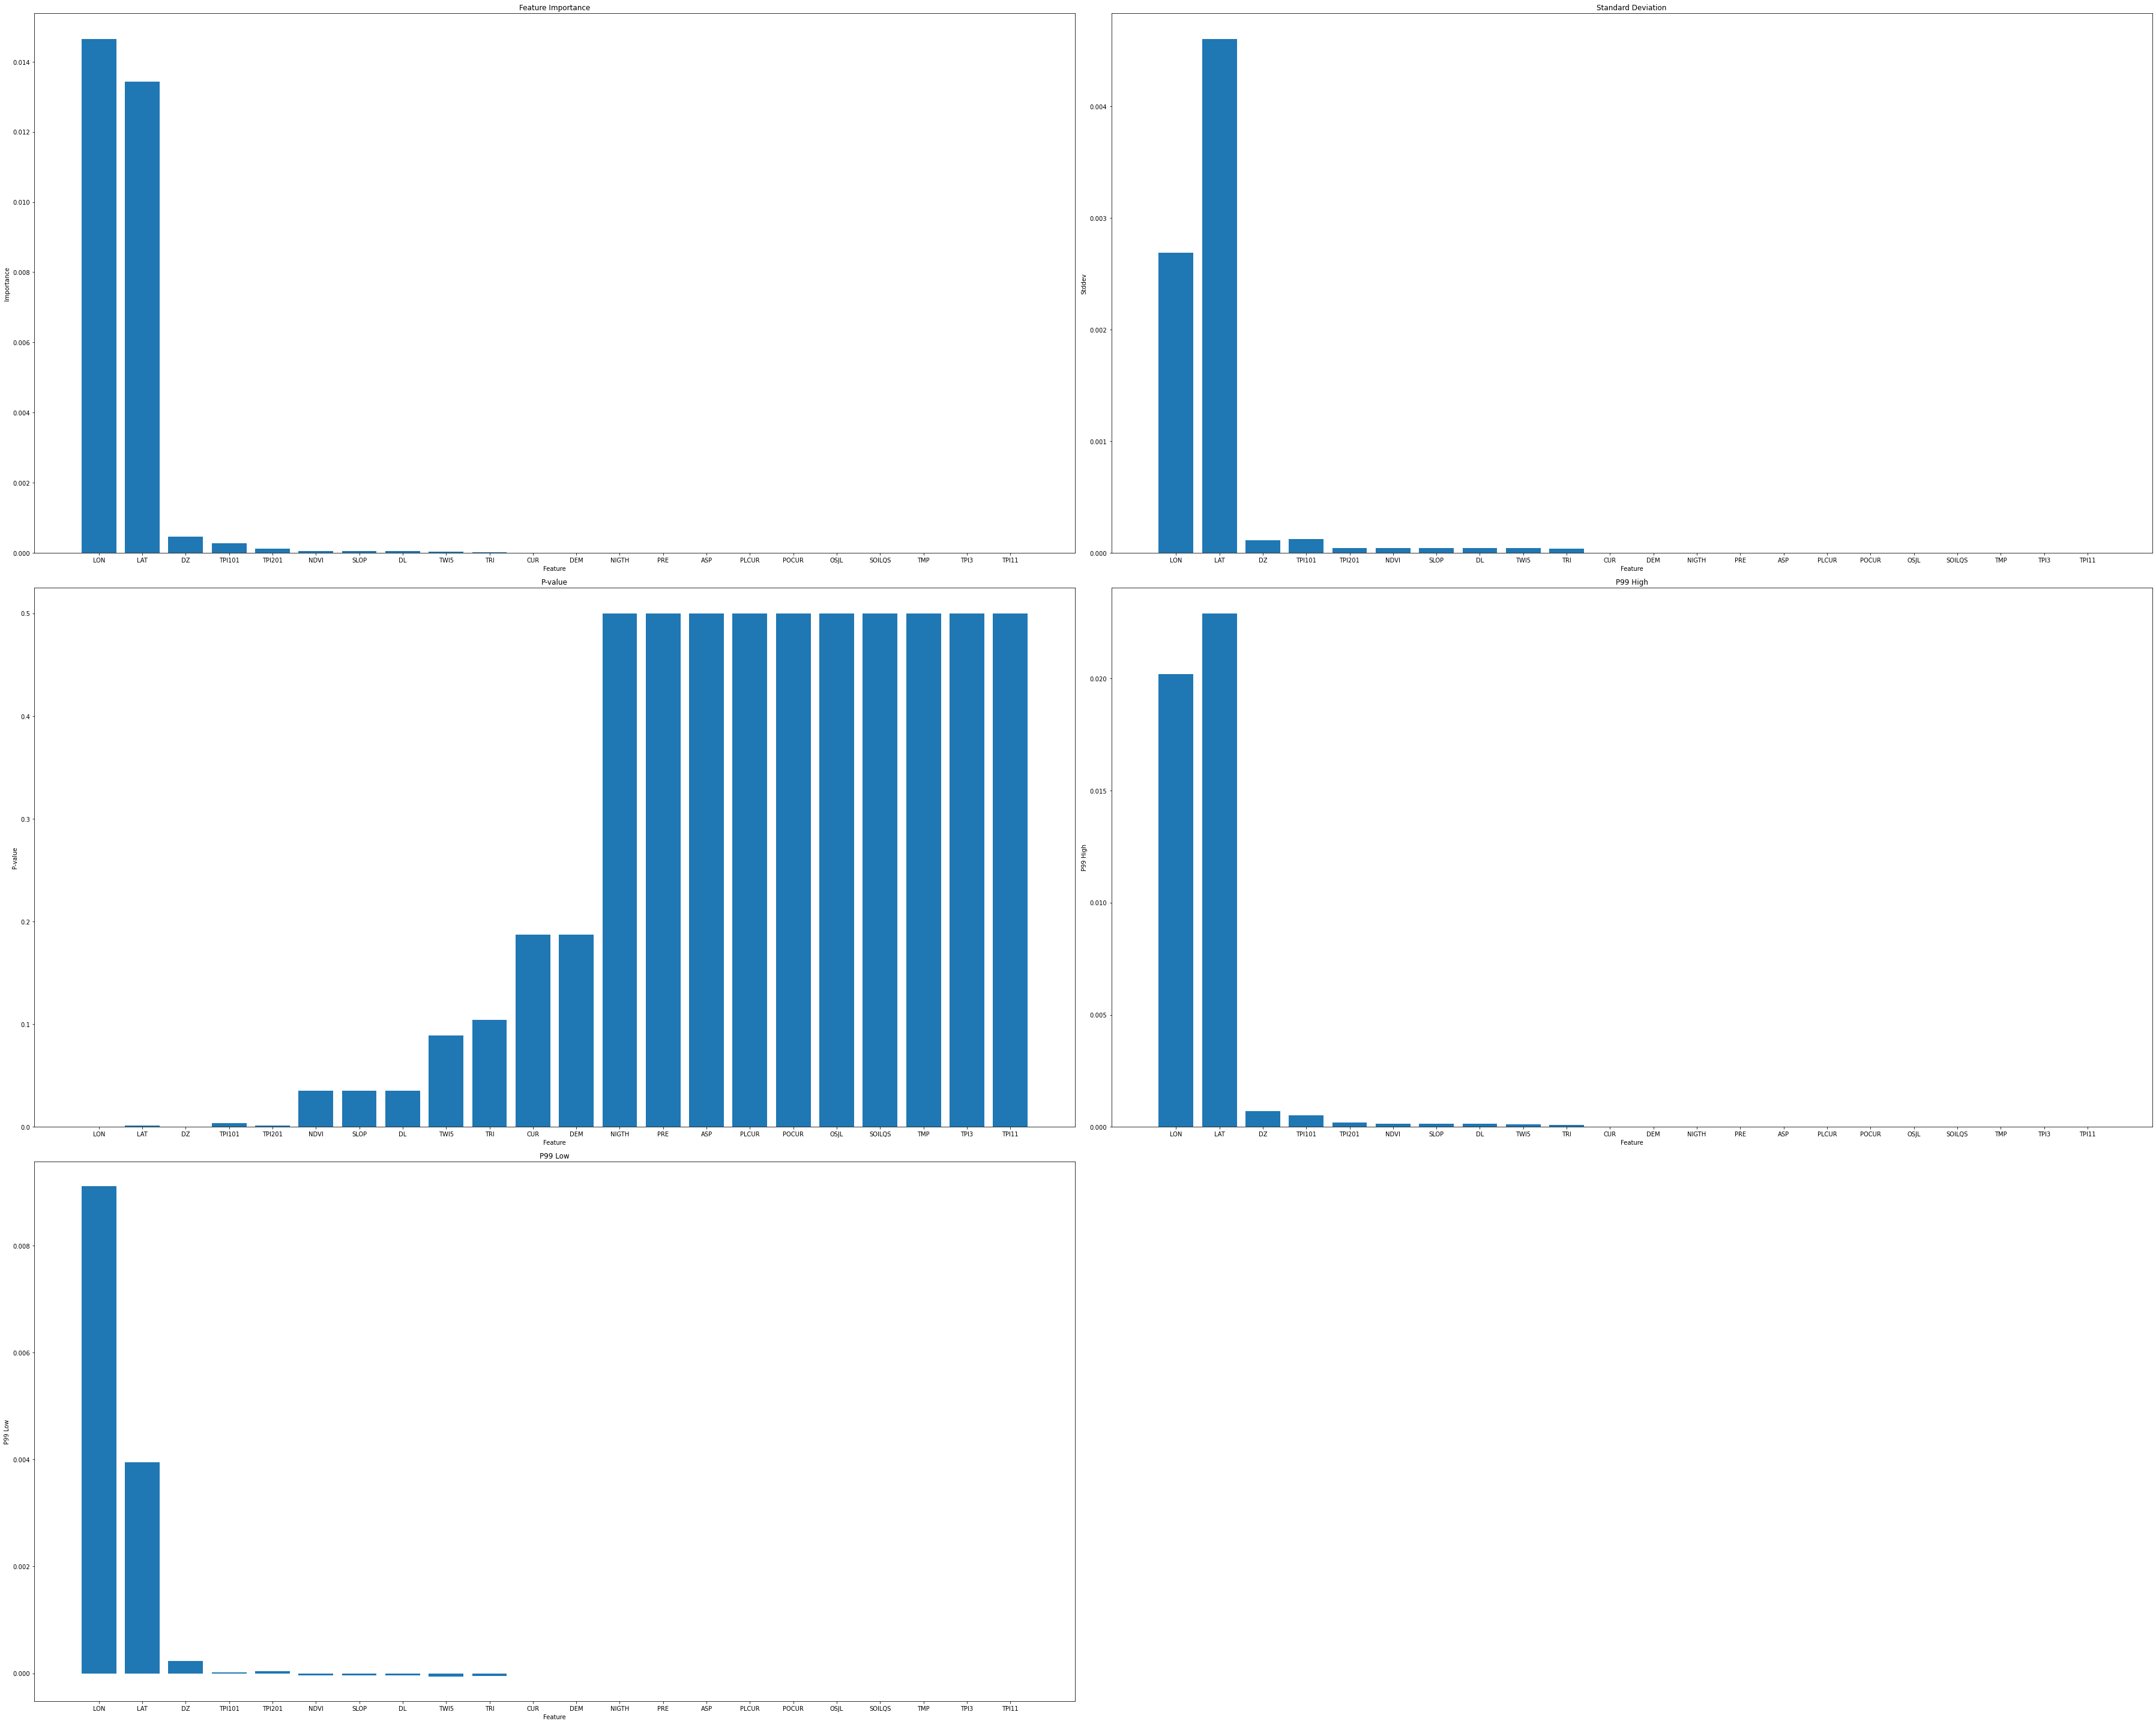

In [17]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""